# Basic Analysis

In [1]:
from __future__ import division

import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import scipy.special as sp

import matplotlib.font_manager as font_manager
%matplotlib inline

def poisson(x, mu):
    return np.exp(x * np.log(mu) - mu  - sp.gammaln([a + 1 for a in x]))

def deviation(obs, exp, err):
    return (obs - exp) / err

def myChi(obs, exp, err, ddof):
    return np.sum(deviation(obs, exp, err)**2)/(len(obs) - ddof)

In [2]:
data = pd.read_csv("CountingData.csv"); data;

In [3]:
background = data.iloc[1:201,:2]; 
sample = data.iloc[1:201, 3:5]; 

In [4]:
def countData(d):
    d.columns = ['time', 'counts']
    d['rate'] = d.counts.div(d.time)
    
    d_counts = pd.DataFrame()
    d_counts['totalCount'] = d.groupby('counts').size();
    d_counts['error'] = d_counts.totalCount.apply(np.sqrt);
    N = d_counts.totalCount.sum()
    d_counts.frequency = d_counts.totalCount.div(N)
    d_counts['frequencyError'] = d_counts.error.div(N)
    return d, d_counts
    
background, background_counts = countData(background);
sample, sample_counts = countData(sample);

In [5]:
def fitPoisson(dat):
    n = list(dat.index)
    mu, cov = op.curve_fit(poisson, n, 
                           dat.frequency,
                           p0 = dat.frequency.idxmax(), 
                           sigma=dat.frequencyError, 
                           absolute_sigma=True)
    muerr = np.sqrt(np.diag(cov))
    
    dat.mu = mu[0]
    dat.muErr = muerr[0]
    dat.muChi = myChi(dat.frequency, poisson(n, mu), dat.frequencyError, 2)
    
    dat.x = np.linspace(dat.index[0], dat.index[-1])
    dat.fit = poisson(dat.x, dat.mu)
    dat.lowerfit = poisson(dat.x, dat.mu - dat.muErr)
    dat.upperfit = poisson(dat.x, dat.mu + dat.muErr)


In [6]:
pltStyle = {'ecolor':'grey', 'facecolor':'none', 'edgecolor':'black', 'width':0.8}

def createPlot():
    axis_font = {'fontname':'Arial', 'size':'14'}
    title_font = {'fontname':'Arial', 'size':'16'}
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
    font_prop = font_manager.FontProperties(fname=font_path, size=14)

    fig, ( (ax_topleft, ax_topright), (ax_bottomleft, ax_bottomright)) = plt.subplots(nrows=2, 
                                                                                  ncols=2)

    fig.set_size_inches(11, 8)
    ax_bottomleft.set_xlabel('counts', **axis_font);
    ax_bottomright.set_xlabel('counts', **axis_font);
    ax_topleft.set_ylabel('frequency', **axis_font);
    ax_bottomleft.set_ylabel('deviation', **axis_font);
    ax_topleft.set_title('Background', **title_font);
    ax_topright.set_title('Sample', **title_font);

    ax_topleft.set_xlim([background_counts.index[0] - 1, background_counts.index[-1] + 1]);
    ax_bottomleft.set_xlim([background_counts.index[0] - 1, background_counts.index[-1] + 1]);

    ax_bottomright.set_xlim([sample_counts.index[0] - 1, sample_counts.index[-1] + 1]);
    ax_topright.set_xlim([sample_counts.index[0] - 1, sample_counts.index[-1] + 1]);
    
    return fig, ax_topleft, ax_topright, ax_bottomleft, ax_bottomright

Background fit has mean of 3.66 +- 0.14 counts, with a chi^2 of 0.54


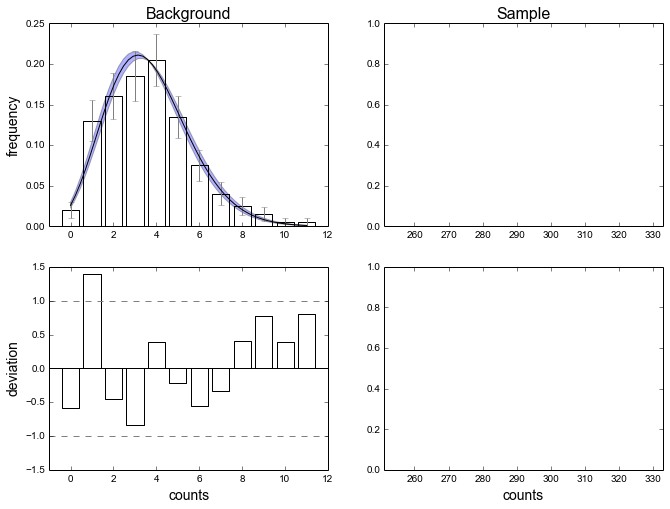

In [13]:
def plotBackground(dat, ax, residue_ax):
    leftEdges = dat.index - pltStyle['width']/2
    xmin = dat.index[0] - 1
    xmax = dat.index[-1] + 1
    descStr = "Background fit has mean of {0:.2f} +- {1:0.2f} counts, with a chi^2 of {2:.2f}"

    ax_topleft.bar(leftEdges, dat.frequency, yerr=dat.frequencyError, **pltStyle);
    
    ax_topleft.plot(dat.x, dat.fit, color='black')
    print descStr.format(dat.mu, dat.muErr, dat.muChi)
    
    ax.fill_between(dat.x, dat.lowerfit, dat.upperfit, facecolor='blue', alpha=0.3)
    
    residue_ax.bar(leftEdges, 
                      deviation(dat.frequency, poisson(dat.index, dat.mu), dat.frequencyError), 
                      **pltStyle);
    residue_ax.hlines(y=1, xmin=xmin, xmax=xmax, color='grey', linestyle='--')
    residue_ax.hlines(y=-1, xmin=xmin, xmax=xmax, color='grey', linestyle='--')
    residue_ax.hlines(y=0, xmin=xmin, xmax=xmax, color='black')
    
fitPoisson(background_counts)
fitPoisson(sample_counts)
fig, ax_topleft, ax_topright, ax_bottomleft, ax_bottomright = createPlot()
plotBackground(background_counts, ax_topleft, ax_bottomleft)

Background fit has mean of 3.66 +- 0.14 counts, with a chi^2 of 0.54
Background fit has mean of 291.36 +- 1.44 counts, with a chi^2 of 1.10


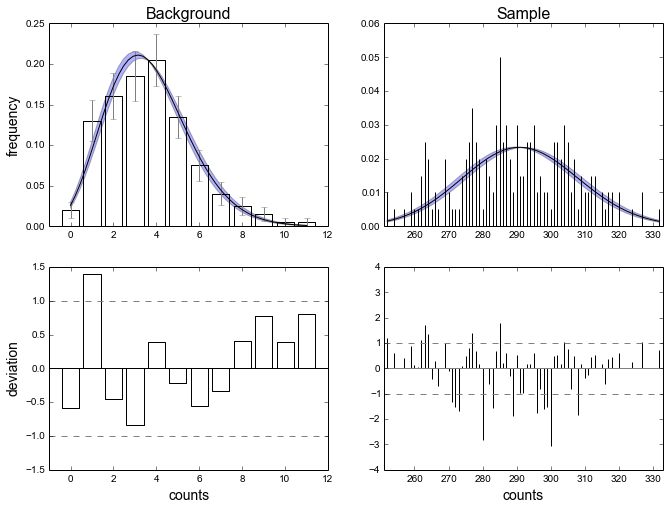

In [19]:
def plotSample(dat, ax, residue_ax):
    xmin = dat.index[0] - 1
    xmax = dat.index[-1] + 1
    descStr = "Background fit has mean of {0:.2f} +- {1:0.2f} counts, with a chi^2 of {2:.2f}"
    print descStr.format(dat.mu, dat.muErr, dat.muChi)

    ax.vlines(dat.index, 0, dat.frequency)
    ax.plot(dat.x, dat.fit, color='black')
    ax.fill_between(dat.x, dat.lowerfit, dat.upperfit, facecolor='blue', alpha=0.3)
    
    residue_ax.vlines(dat.index, 0, 
                      deviation(dat.frequency, poisson(dat.index, dat.mu), dat.frequencyError));
    residue_ax.hlines(y=1, xmin=xmin, xmax=xmax, color='grey', linestyle='--')
    residue_ax.hlines(y=-1, xmin=xmin, xmax=xmax, color='grey', linestyle='--')
    residue_ax.hlines(y=0, xmin=xmin, xmax=xmax, color='grey')
    residue_ax.set_ylim([-4, 4])

                   
fitPoisson(background_counts)
fitPoisson(sample_counts)
fig, ax_topleft, ax_topright, ax_bottomleft, ax_bottomright = createPlot()
plotBackground(background_counts, ax_topleft, ax_bottomleft)
plotSample(sample_counts, ax_topright, ax_bottomright)

No absolute (physical) sigma forces reduced chi to be one, by fiddling with the parameter error.

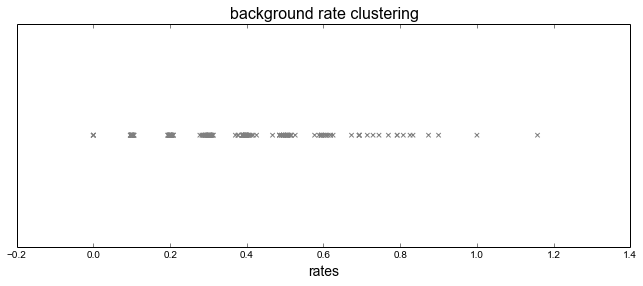

In [13]:
rate_fig, rate_ax = plt.subplots()
rate_ax.scatter(list(background.rate), 
            np.zeros(background.rate.shape[0]) + 0, 
            marker='x', color='grey');
rate_fig.set_size_inches(11, 4)
rate_ax.set_title('background rate clustering', **title_font);
rate_ax.set_xlabel('rates', **axis_font);
rate_ax.get_yaxis().set_visible(False)

#Automatic Error Analysis

In [ ]:
from pint import UnitRegistry
ureg = UnitRegistry()
background['time'] = background['time'].apply(lambda t: (t * ureg.second).plus_minus(0.05))
sample['time'] = sample['time'].apply(lambda t: (t * ureg.second).plus_minus(0.05))